
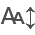

In [12]:
from Plots import plot_political_label_counts, custom_show_fig, plot_box_plot_rating_politics, plot_political_outliers, plot_box_plot_confidence_politics
from FilmCollector import Film_collector
import asyncio
from Utils import json_to_dataframe, predict_reviews, split_by_politics, sort_by_confidence
import nest_asyncio
import pandas as pd
import json
from IPython.display import display, HTML
from itables import init_notebook_mode, show
from plotly.subplots import make_subplots
import plotly.graph_objects as go
init_notebook_mode(all_interactive=True)
import warnings
warnings.filterwarnings('ignore')
from string import Template
import os

In [13]:
FILM_ID = 'tt10676048'

In [14]:
nest_asyncio.apply()
collector = Film_collector()
async def get_film_data():
    return await collector.get_all(FILM_ID, False, False)

film_data_json, df_reviews = asyncio.get_event_loop().run_until_complete(get_film_data())
df_film_data = json_to_dataframe( json.loads(film_data_json))

In [15]:
def dataframe_to_movie_data(df):
    movie_info = df.iloc[0].to_dict()
    movie_data = {
        'movie_title': movie_info.get('Name', 'N/A'),
        'imdb_link': movie_info.get('URL', 'N/A'),
        'release_date': movie_info.get('DatePublished', 'N/A'),
        'rating': str(movie_info.get('RatingValue', 'N/A')),
        'votes': str(movie_info.get('RatingCount', 'N/A')),
        'genres': movie_info.get('Genres', 'N/A'),
        'duration': movie_info.get('Duration', 'N/A'),
        'tags': movie_info.get('Keywords', 'N/A'),
        'poster_url': movie_info.get('Poster', 'N/A')
    }

    return movie_data

movie_data = dataframe_to_movie_data(df_film_data)
with open('document_creator/movie_template.html', 'r') as file:
    html_template = file.read()

# Replace placeholders manually
for key, value in movie_data.items():
    html_template = html_template.replace('{{'+ key+ '}}', str(value))  

display(HTML(html_template))

In [16]:
df_reviews_predicted = predict_reviews(df_reviews)

In [ ]:
def dataframe_to_json_context(df_predicated, df_film):
    df_left = df_predicated[df_predicated['politics'] == 'left']
    df_right = df_predicated[df_predicated['politics'] == 'right']
    df_neutral = df_predicated[df_predicated['politics'] == 'neutral']
    df_left_1 = df_left[df_left['rating'] == 1]
    df_left_1.loc[:, 'politics'] = 'left 1'
    df_left_10 = df_left[df_left['rating'] == 10]
    df_left_10.loc[:, 'politics'] = 'left 10'
    df_right_1 = df_right[df_right['rating'] == 1]
    df_right_1.loc[:, 'politics'] = 'right 1'
    df_right_10 = df_right[df_right['rating'] == 10]
    df_right_10.loc[:, 'politics'] = 'right 10'
    df_right_filtered = df_right[~df_right['rating'].isin([1, 10])]
    df_left_filtered = df_left[~df_left['rating'].isin([1, 10])]
    
    df_concatenated = pd.concat([
        df_neutral,
        df_right_filtered,
        df_left_filtered,
        df_left_1,
        df_left_10,
        df_right_1,
        df_right_10,
    ], ignore_index=True)
    
    df_concatenated = df_concatenated.dropna(subset=['rating'])
    data = df_concatenated[['rating', 'politics', 'confidence']].to_dict(orient='records')
    context = {
        'data': json.dumps(data),
        'imdb_score': str(df_film['RatingValue'][0]),
        'imdb_doc_count': str(df_film['RatingCount'][0]),
    }
    return context
    

json4 = dataframe_to_json_context(df_reviews_predicted, df_film_data)

file_path = os.getcwd() + '/document_creator/movie_score.html'
with open(file_path, 'r') as file:
    src = Template(file.read())
html = src.safe_substitute(json4)
display(HTML(html))

In [17]:
fig1 = plot_political_label_counts(df_reviews_predicted)
fig2 = plot_political_outliers(df_reviews_predicted)
fig3 = plot_box_plot_rating_politics(df_reviews_predicted)
fig4 = plot_box_plot_confidence_politics(df_reviews_predicted)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Political Counts", "Political Outliers", "Rating by Politics", "Rating by Confidence"),
    specs=[[{}, {}], 
           [{}, {}]]  
)

for trace in fig1.data:
    fig.add_trace(go.Bar(x=trace.x, y=trace.y, marker=trace.marker, name=trace.name), row=1, col=1)
for trace in fig2.data:
    fig.add_trace(go.Bar(x=trace.x, y=trace.y, marker=trace.marker, name=trace.name), row=1, col=2)
for trace in fig3['data']:
    fig.add_trace(trace, row=2, col=1)
for trace in fig4['data']:
    fig.add_trace(trace, row=2, col=2)

fig.update_yaxes(title_text="Number of Reviews", row=1, col=1) 
fig.update_yaxes(title_text="Number of Outliers", row=1, col=2)  
fig.update_yaxes(title_text="Rating", row=2, col=1)  
fig.update_yaxes(title_text="Confidence", row=2, col=2)  


fig.update_layout(
    autosize=True,
    showlegend=True,
    height=1000,
)
custom_show_fig(fig)

## Neutral

In [18]:
## Style Tables 
def display_dataframe(df):
    if 'review_title' in df.columns:
        df['review_title'] = df['review_title'].apply(lambda x: f'<div style="white-space: normal;">{x}</div>')
    if 'document' in df.columns:
        df['document'] = df['document'].apply(lambda x: f'<div style="white-space: normal;">{x}</div>')


    show(
        df,
        buttons=[
            {"extend": "csvHtml5", "title": "Countries"},
            {"extend": "excelHtml5", "title": "Countries"},
        ],
        columnDefs=[
            {"className": "dt-left", "targets": "_all"},
            {"targets": [0], "visible": False},
            {"targets": [1], "width": "200px", "title": "Title"},  
            {"targets": [2], "width": "1000px", "title": "Review"}, 
            {"targets": [3], "title": "Politics"}, 
            {"targets": [4], "title": "Confidence"}, 
            {"targets": [5], "title": "Rating"}, 
            {"targets": [6], "title": "Length"}, 
        ],
        pageLength=5,
        scrollX=True,
        escapeHtml=False, 
        autoWidth=False 
    )


In [19]:
df_review_neutral = split_by_politics(df_reviews_predicted, 'neutral')
df_review_neutral = sort_by_confidence(df_review_neutral)
display_dataframe(df_review_neutral)

## Left

In [20]:
df_reviews_left = split_by_politics(df_reviews_predicted, 'left')
df_reviews_left = sort_by_confidence(df_reviews_left)
display_dataframe(df_reviews_left)

## Right

In [21]:
df_reviews_right = split_by_politics(df_reviews_predicted, 'right')
df_reviews_right = sort_by_confidence(df_reviews_right)
display_dataframe(df_reviews_right)

### Disclaimer: Non-Political Affiliation
The content and context of this project do **not reflect any political affiliations** or ideologies of the creator. Any interpretations or assumptions linking the project's material to specific political views are unfounded and not endorsed.

### Content Sensitivity Disclaimer
Please be advised that this project may contain material that could be considered offensive to some individuals. This includes content derived from user contributions on IMDb. Viewer discretion is advised. The content is presented for educational, informational, or research purposes only and does not intend to harm, offend, or disparage **any group** or **individual**